<p class="alert alert-success" style="padding:1em">
To use SMT, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub

<p class="alert alert-warning" style="padding:1em">
To use PODI function from SMT, please refer to the dedicated notebook: SMT_PODI_tutorial.ipynb
</p>

# Transonic Airfoil Pressure Prediction with Kriging Interpolation and POD = PODI

In this tutorial, we demonstrate how to analyze airfoil pressure data using Principal Orthogonal Decomposition (POD) and surrogate modeling with Kriging (KRG), leveraging the Gaussian process framework. The goal is to predict pressure distributions on a transonic airfoil under various flight conditions.

In [1]:
import numpy as np
import os
from smt.applications import PODI
import matplotlib.pyplot as plt
import matplotlib.tri as tri

### Data Loading and Processing for Transonic Airfoil Analysis

Data can be loaded at:
https://filesender.renater.fr/?s=download&token=c57ec54a-9710-49b9-8693-044fae1b7a71

1. **Load the Dataset**: The `TransonicRAE` class is instantiated with paths to the data directory and the specific target field ('Pressure') for analysis.

2. **Normalize the Data**:
   - **Conditions**: The angle of attack (`Alpha`) and freestream velocity (`Vinf`). As SMT normalized the input data, no transformation is done here
   - **Target Field (Pressure)**: Pressure data is normalized using the mean and standard deviation for model stability and efficient training.
3. **Split the Data**: The dataset is split into training and test sets based on specified ratios to ensure robust model evaluation.


In [121]:
data_directory = '../../data/' # Adjust this path as needed
class TransonicRAE:
    def __init__(self, data_directory):
        print("Processing dataset...")
        self.dataset, self.coef_norm = self.process_data(data_directory)

    def process_data(self, data_directory):
        print("Loading raw data")
        db = np.load(os.path.join(data_directory, "db_random_reduced.npy"), allow_pickle=True).item()
        
        conditions = np.column_stack((db["Alpha"], db["Vinf"]))

        self.X_coord = (
            2
            * (db["Xcoordinate"][0] - db["Xcoordinate"][0].min())
            / (db["Xcoordinate"][0].max() - db["Xcoordinate"][0].min())
            - 1
        )
        self.Y_coord = (
            2
            * (db["Ycoordinate"][0] - db["Ycoordinate"][0].min())
            / (db["Ycoordinate"][0].max() - db["Ycoordinate"][0].min())
            - 1
        )

        # Normalize target field
        mean_out = db['Pressure'].mean()
        std_out = db['Pressure'].std()
        normalized_field = (db['Pressure'] - mean_out) / std_out

        coef_norm = {"mean": mean_out, "std": std_out}

        return (conditions, normalized_field), coef_norm

    def create_splits(self, train_ratio=0.8, test_ratio=0.2, seed=42):
        np.random.seed(seed)
        num_samples = self.dataset[0].shape[0]
        indices = np.random.permutation(num_samples)

        train_end = int(train_ratio * num_samples)

        train_indices = indices[:train_end]
        test_indices = indices[train_end:]
        
        train_input, train_output = (self.dataset[0][train_indices], self.dataset[1][train_indices])
        test_input, test_output = (self.dataset[0][test_indices], self.dataset[1][test_indices])

        return train_input, train_output, test_input, test_output



# Create dataset instance
dataset = TransonicRAE(data_directory)
train_x,P_train,test_x, P_test = dataset.create_splits()
coef_norm = dataset.coef_norm
print("Number of training points", np.shape(train_x)[0])
print("Number of testing points", np.shape(test_x)[0])

X = dataset.X_coord
Y = dataset.Y_coord
print("Shape dataset for pressure (number of mesh points)", np.shape(X))
# Load Airfoil
airfoil = np.load(os.path.join(data_directory, "airfoil.npy"))
X_airfoil = airfoil[:, 0] - 0.5
Y_airfoil = airfoil[:, 1]
print(
    "Shape data for airfoil (Coordinates of the airfoil boundary.)",
    np.shape(X_airfoil)
)

Processing dataset...
Loading raw data
Number of training points 80
Number of testing points 20
Shape dataset for pressure (number of mesh points) (27499,)
Shape data for airfoil (Coordinates of the airfoil boundary.) (691,)


## 📊 Training and Testing Data Distribution



The parameter space consists of:
- **Alpha (α)**: Angle of attack in degrees 
- **Inflow Velocity**: Flow inflo velocity magnitude (divide by 343 m/s for Mach number)

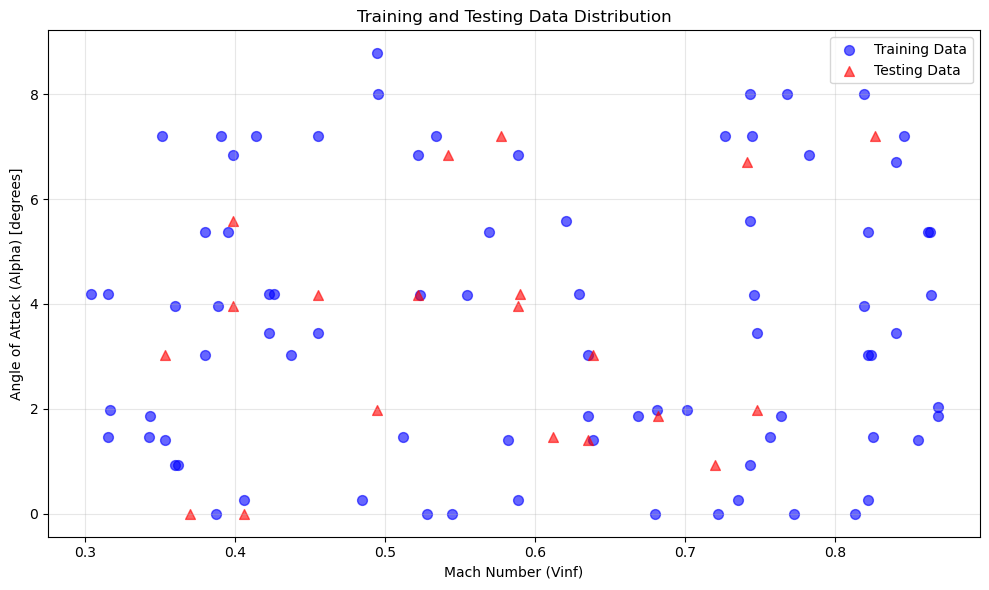

Training data range - Alpha: [0.00, 8.78], Mach: [0.30, 0.87]
Testing data range - Alpha: [0.00, 7.20], Mach: [0.35, 0.83]


In [109]:
# Cell 1: Plot scatter of training and testing data in Mach vs Alpha space
plt.figure(figsize=(10, 6))
plt.scatter(train_x[:, 1]/347, train_x[:, 0], c='blue', alpha=0.6, s=50, label='Training Data', marker='o')
plt.scatter(test_x[:, 1]/347, test_x[:, 0], c='red', alpha=0.6, s=50, label='Testing Data', marker='^')
plt.xlabel('Mach Number (Vinf)')
plt.ylabel('Angle of Attack (Alpha) [degrees]')
plt.title('Training and Testing Data Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training data range - Alpha: [{train_x[:, 0].min():.2f}, {train_x[:, 0].max():.2f}], Mach: [{train_x[:, 1].min()/347:.2f}, {train_x[:, 1].max()/347:.2f}]")
print(f"Testing data range - Alpha: [{test_x[:, 0].min():.2f}, {test_x[:, 0].max():.2f}], Mach: [{test_x[:, 1].min()/347:.2f}, {test_x[:, 1].max()/347:.2f}]")

## Create Snapshot Matrix (collecting all training snapshots)

Create the Snapshot Matrix from the Dataset 
Before applying Proper Orthogonal Decomposition, we need to prepare our data properly. This preprocessing step is crucial for meaningful POD results.
Mean Field Removal

In [122]:
# Calculate the mean across the pressure samples and remove it
P_mean = np.mean(P_train, axis=0)
P_train = P_train - P_mean
# Assemble Snapshot Matrix
U = P_train.T
print("Dimension of the snapshot matrix:", np.shape(U))

Dimension of the snapshot matrix: (27499, 80)



## 🧮 Proper Orthogonal Decomposition + Interpolation with SMT

### POD Mathematical Framework

**Singular Value Decomposition:**
The snapshot matrix **U** is decomposed as:
U = Φ Σ Ψᵀ
where:
- **Φ** ∈ ℝ^(n×r): Spatial POD modes (orthonormal basis) φ
- **Σ** ∈ ℝ^(r×r): Diagonal matrix of singular values (σ₁ ≥ σ₂ ≥ ... ≥ σᵣ)
- **Ψ** ∈ ℝ^(m×r): Reduced coefficients a

**Reduced-Order Representation:**
Any pressure field can be reconstructed as:
p(x,μ) ≈ p̄(x) + Σᵢ₌₁ʳ aᵢ(μ) φᵢ(x)
where:
- **p̄(x)**: Mean pressure field
- **aᵢ(μ)**: POD coefficients (functions of parameters μ = [α, M])
- **φᵢ(x)**: POD spatial modes
- **r**: Number of retained modes

### Interpolation Strategy

**Problem:** Given new parameters μ*, predict coefficients **a(μ*)**

**Solution:** Train Gaussian Process regressors:
aᵢ(μ) ~ GP(0, k(μ,μ'))

**PODI Workflow:**
1. Compute POD modes from training data
2. Project training fields onto POD basis → get training coefficients
3. Train GP models: μ → aᵢ for each mode i
4. For prediction: μ* → a*(μ*) → reconstruct p*(x,μ*)

In [111]:
podi = PODI() #Initialize PODI model
latent_dim = 20
podi.compute_pod(database=U, n_modes=latent_dim)

#### PODI computation with a threshold value to choose the number of modes

In [112]:
seed_pod = 42
threshold = 0.99
podi.compute_pod(database=U, tol=threshold, seed=seed_pod)

In [113]:
# Results of the POD + SVD
n_modes = podi.get_n_modes()
print(f"{n_modes} modes were kept.")

13 modes were kept.


### Plotting the POD modes

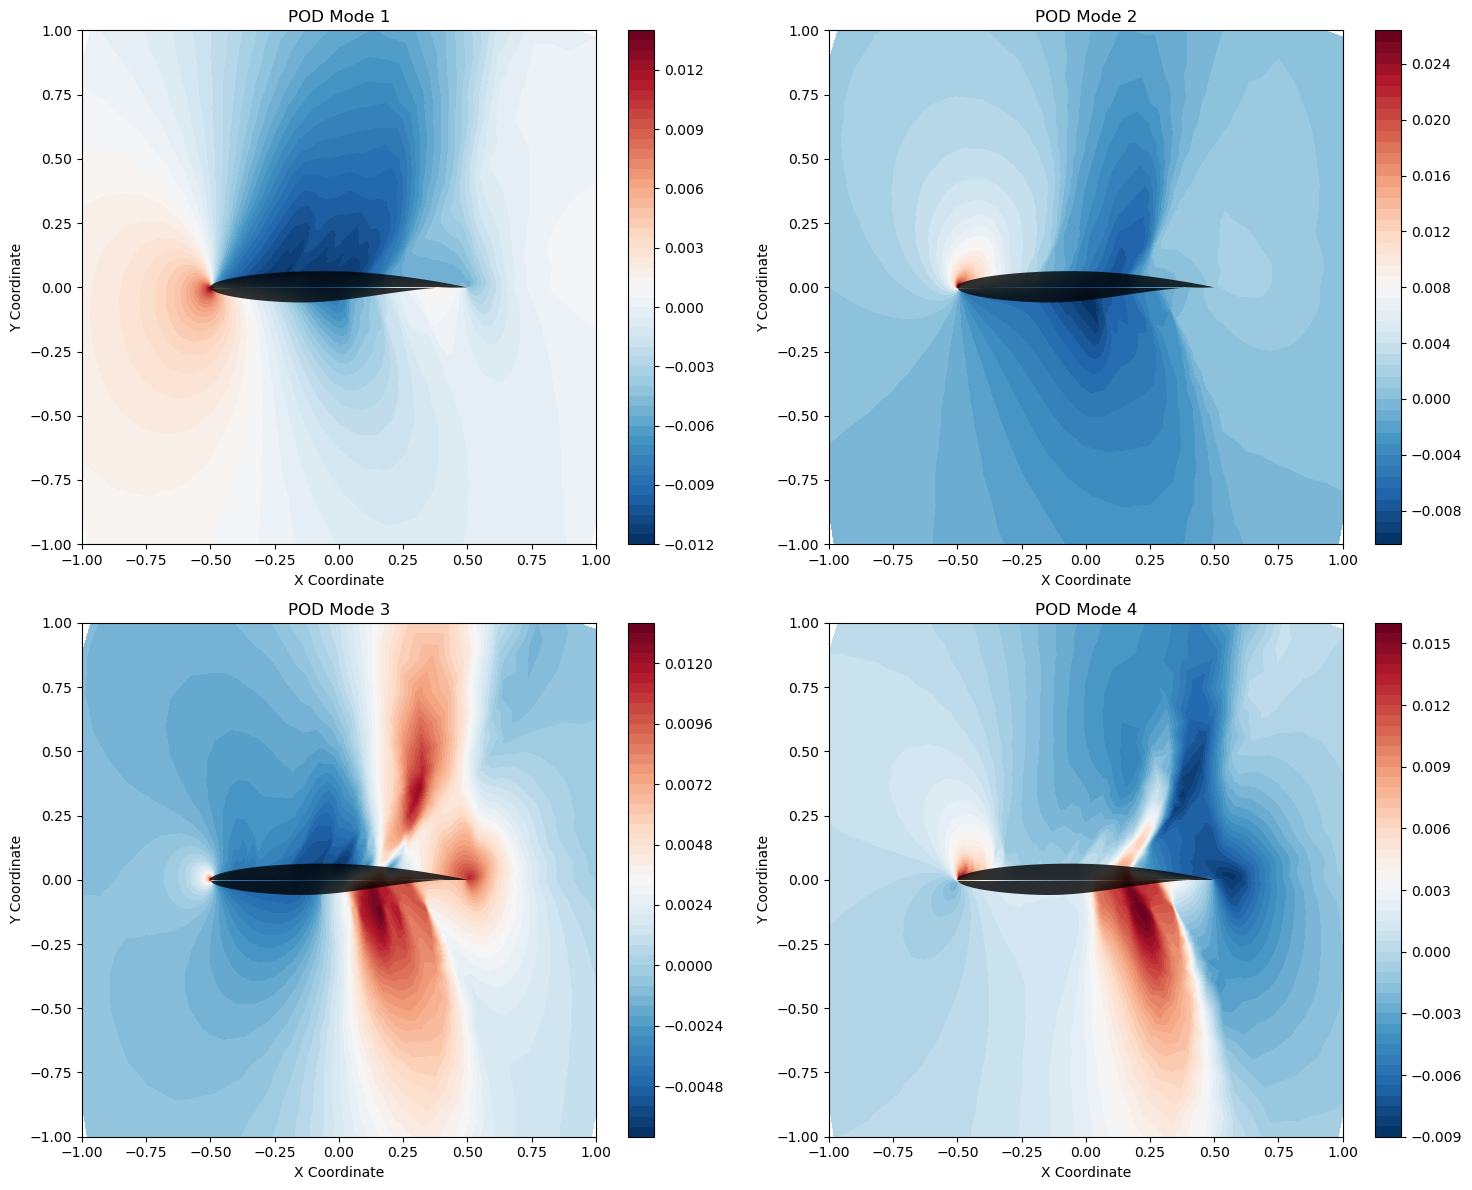

POD Mode Energy Content:
Mode 1: 56.25% | Cumulative: 56.25%
Mode 2: 26.43% | Cumulative: 82.67%
Mode 3: 6.86% | Cumulative: 89.53%
Mode 4: 4.21% | Cumulative: 93.74%
Mode 5: 1.93% | Cumulative: 95.68%
Mode 6: 1.01% | Cumulative: 96.69%
Mode 7: 0.61% | Cumulative: 97.30%
Mode 8: 0.49% | Cumulative: 97.78%
Mode 9: 0.38% | Cumulative: 98.16%
Mode 10: 0.29% | Cumulative: 98.45%


In [114]:
# Cell 2: Plot the first 4 POD modes
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Create triangulation for contour plotting
triang = tri.Triangulation(X, Y)

for i in range(4):
    ax = axes[i]
    
    # Get the POD mode (spatial mode)
    mode = podi.get_basis()[:, i]
    
    # Plot the mode using tricontourf
    contour = ax.tricontourf(triang, mode, levels=50, cmap='RdBu_r')
    ax.set_title(f'POD Mode {i+1}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    
    # Add colorbar
    fig.colorbar(contour, ax=ax, orientation='vertical')
    
    # Overlay the airfoil in black
    ax.fill(X_airfoil, Y_airfoil, 'black', alpha=0.8)
    ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

# Print singular values/eigenvalues information
singular_values = podi.singular_values
total_energy = np.sum(singular_values**2)
cumulative_energy = np.cumsum(singular_values**2) / total_energy

print("POD Mode Energy Content:")
for i in range(min(10, len(singular_values))):
    print(f"Mode {i+1}: {singular_values[i]**2/total_energy*100:.2f}% | Cumulative: {cumulative_energy[i]*100:.2f}%")

## 🎛️ Gaussian Process Configuration & Training

### Kriging (Gaussian Process) Setup

**Correlation Function - Matérn 5/2:**
k(x,x') = σ² (1 + √5r + 5r²/3) exp(-√5r)
where r = ||x-x'||/ℓ (scaled distance)

**Key Hyperparameters:**
- **σ²**: Process variance (output scale)
- **ℓ**: Length scales per input dimension [α, M]
- **nugget**: Numerical stability term (1e-10) for matrix conditioning

**Hyperparameter Optimization:**
- **Method**: COBYLA (Constrained Optimization BY Linear Approximation)
- **Objective**: Maximize log marginal likelihood
- **Result**: Optimal correlation lengths and variance parameters

### Training Process

**Data Normalization:** SMT automatically scales inputs μ = [α, M] to unit hypercube

**Per-Mode Training:** For each POD coefficient aᵢ:
1. **Input**: Parameter vectors μⱼ = [αⱼ, Mⱼ] 
2. **Output**: Coefficient values aᵢ(μⱼ)
3. **GP Training**: Learn μ → aᵢ mapping with uncertainty quantification

**Result:** r independent GP models ready for prediction and uncertainty estimation

In [120]:
# Choosing the kriging based models (default is Kriging "KRG")
podi.set_interp_options(
    interp_type="KRG",
    interp_options=[{"corr": "matern52", "nugget": 1e-10, "hyper_opt": "Cobyla"}],
)
# Setting the training values: SMT is doing the data normalization
podi.set_training_values(xt=train_x)
# Training the models
podi.train()

In [116]:
# predicting the desired values with inputs
# SMT is doing the data normalization
xv = test_x
values = podi.predict_values(xv)
variances = podi.predict_variances(xv)


#### Plotting Predictions vs. Ground Truth for Airfoil Pressure

In [117]:
def plot_predictions_vs_truth_with_conditions(
    X_airfoil, Y_airfoil, X, Y, P_pred_list, P_test_list, variances, conditions, num_samples=5, seed=42
):
    """
    Plot predicted and actual pressure distributions for random samples with their conditions and uncertainty.
    Parameters:
    - X_airfoil, Y_airfoil: Coordinates of the airfoil boundary.
    - X, Y: Coordinates for pressure values.
    - P_pred_list, P_test_list: Lists of predicted and actual pressure matrices.
    - variances: Variance predictions with shape (n_mesh_points, n_test_samples)
    - conditions: Array of conditions [alpha, mach] for each sample
    - num_samples: Number of random samples to plot.
    """
    # Generate random indices to select random samples
    np.random.seed(seed)
    sample_indices = np.random.choice(len(P_pred_list), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        # Get conditions for this sample
        alpha, mach = conditions[idx]
        
        # Setting up the plot with 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
        plt.subplots_adjust(wspace=0.3)
        
        # Triangulation for contour plotting
        triang = tri.Triangulation(X, Y)
        
        # Calculate common colorbar limits for pressure plots
        vmin_pressure = min(np.min(P_test_list[idx]), np.min(P_pred_list[idx]))
        vmax_pressure = max(np.max(P_test_list[idx]), np.max(P_pred_list[idx]))
        
        # Plot ground truth
        ax = axes[0]
        contour_gt = ax.tricontourf(
            triang, P_test_list[idx].flatten(), levels=50, 
            vmin=vmin_pressure, vmax=vmax_pressure, cmap="viridis"
        )
        ax.set_title(f"Ground Truth\nα = {alpha:.2f}°, M = {mach:.3f}")
        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        fig.colorbar(contour_gt, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label="Pressure")
        
        # Plot prediction
        ax = axes[1]
        contour_pred = ax.tricontourf(
            triang, P_pred_list[idx].flatten(), levels=50, 
            vmin=vmin_pressure, vmax=vmax_pressure, cmap="viridis"
        )
        ax.set_title(f"PODI Prediction\nα = {alpha:.2f}°, M = {mach:.3f}")
        ax.set_xlabel("X Coordinate")
        fig.colorbar(contour_pred, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label="Pressure")
        
        # Plot uncertainty (standard deviation)
        ax = axes[2]
        # Extract variance for this specific test sample and convert to standard deviation
        variance_field = variances[idx]
        #std_field = np.sqrt(variance_field)
        
        contour_std = ax.tricontourf(
            triang, variance_field.flatten(), levels=50, cmap="viridis"
        )
        ax.set_title(f"Prediction Uncertainty (σ)\nα = {alpha:.2f}°, M = {mach:.3f}")
        ax.set_xlabel("X Coordinate")
        fig.colorbar(contour_std, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, label="Std Dev")
        
        # Overlay the airfoil area in white on all plots
        for ax in axes:
            ax.fill(X_airfoil, Y_airfoil, "white", edgecolor='black', linewidth=0.5)
            ax.set_aspect("equal", "box")
        
        
        plt.show()

### Reconstruct Full field prediction and de-normalize

In [118]:
# To add the mean values and come back to the initial pressure values
P_pred_podi = P_mean.flatten() + values.T
P_pred_podi = P_pred_podi * dataset.coef_norm["std"] + dataset.coef_norm["mean"]
P_pred_var_podi = variances.T * dataset.coef_norm["std"] + dataset.coef_norm["mean"]
P_test = [(p * dataset.coef_norm["std"] + dataset.coef_norm["mean"]) for p in P_test]

# Convert P_pred to a list of arrays, each with shape (num_points, 1) for consistency with P_test
P_pred_list_podi = [
    P_pred_podi[i, :].reshape(-1, 1) for i in range(P_pred_podi.shape[0])
]
P_pred_var_list_podi = [P_pred_var_podi[i, :].reshape(-1, 1) for i in range(P_pred_var_podi.shape[0])
]

### Plot few samples, predictions vs ground_truth and predicted variances

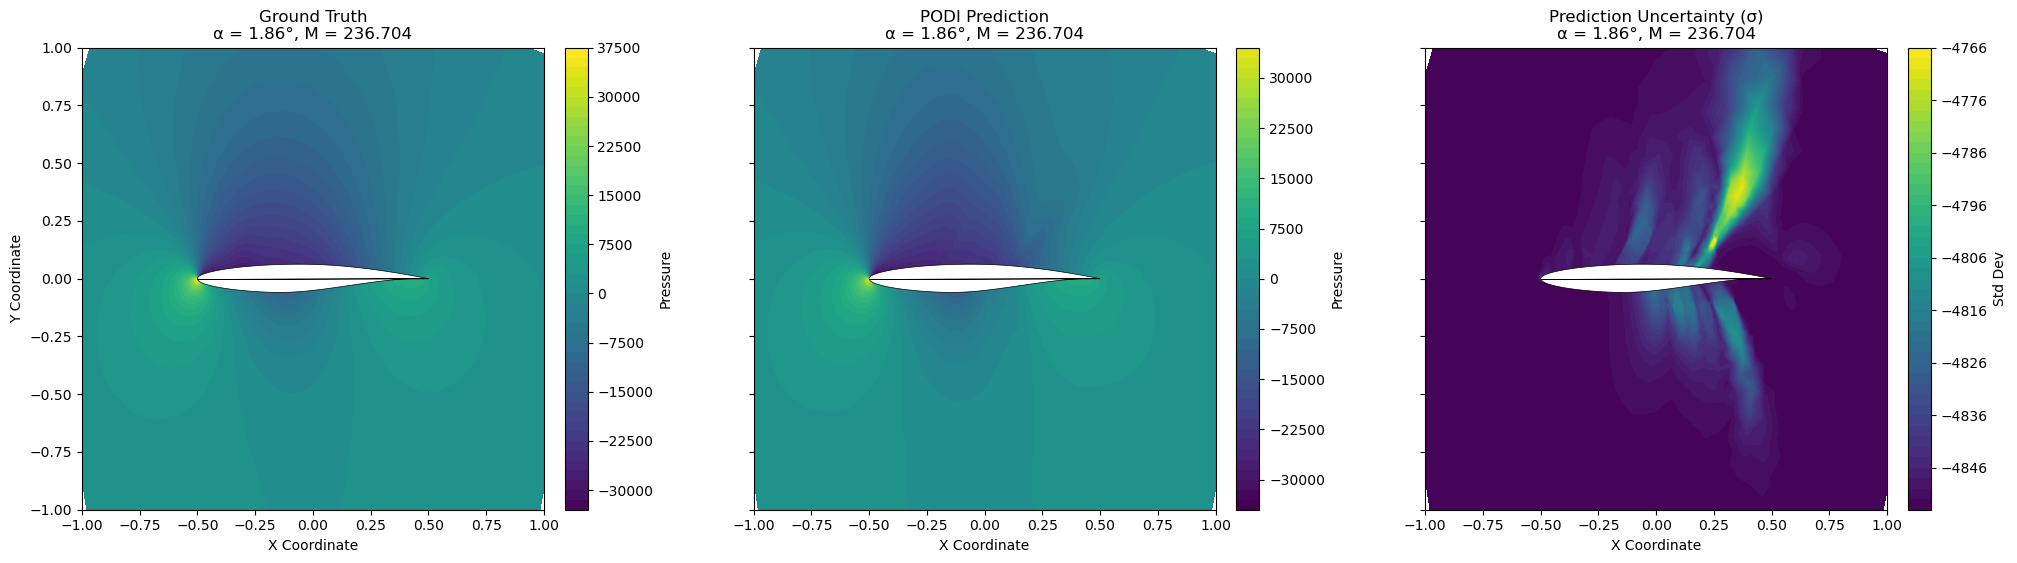

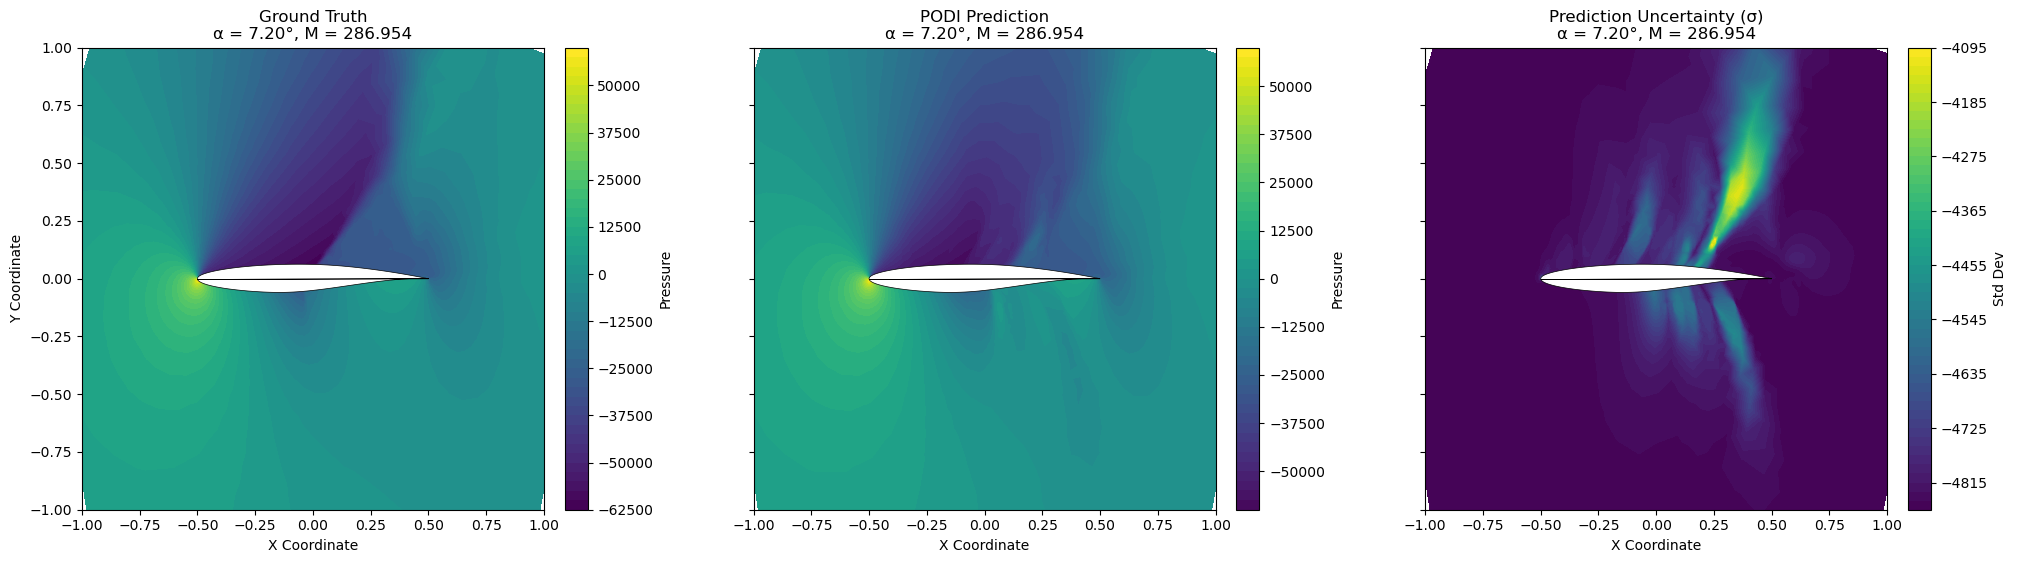

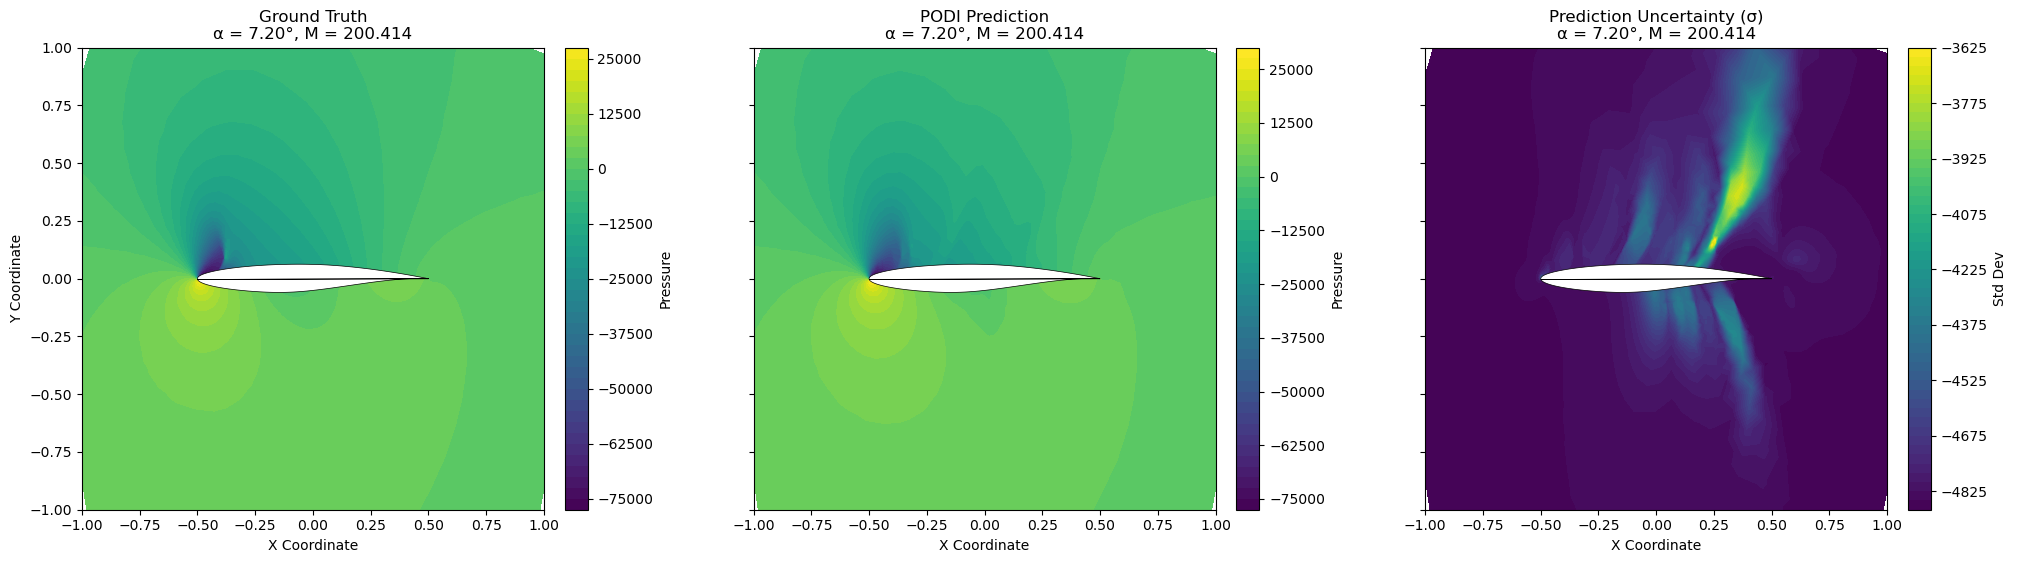

In [119]:
# Example usage
# Number of points chosen randomly to compare the pressure
num_samples = 4


# Plot with conditions
plot_predictions_vs_truth_with_conditions(
    X_airfoil, Y_airfoil, X, Y, 
    P_pred_list_podi,
    P_test,
    P_pred_var_list_podi,
    test_x,  # conditions for test samples
    num_samples=3, 
    seed=42
)

### Questions to answer:

### Why do we need to use POD before interpolation? Can we just directly interpolate in the high dimensionalo space of simulations?
### What do the POD modes represent?
### How is the error in the fields distributed (near shocks for examples)?
### How does the PODI algorithm chooses the number of modes to keep?
### Can you try to use less data for training (by changing training split and see the quality of results? Evaluate the gloabl test error for different train split sizes.